In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm, Normalize

import numpy as np
from magpyx.fdpr2 import console, tools
from magpyx.instrument import set_camera_roi

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from astropy.io import fits
from poppy import zernike
import cupy as cp

from scipy.ndimage import binary_closing, binary_erosion

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
import scoobi.imshows as imshows
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.utils as utils

import lina


# with existing data

In [4]:
config_params = tools.Configuration('fdpr2_fpm')

(3, 256, 256)


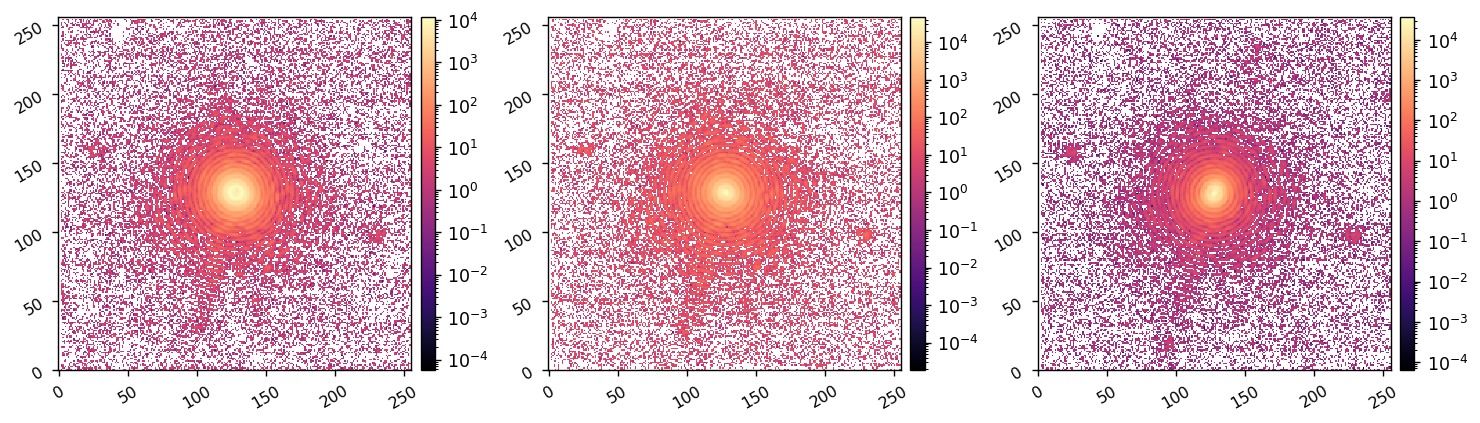

In [3]:
# read in some data
# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20241003-151832.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

# read in some data
# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250103-102551.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

# with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250107-144144.fits') as f:
#     Imeas = f[0].data[0] # data from old response matrix

with fits.open('/opt/MagAOX/calib/fdpr2/kilo_dmdiv/measrespM/measrespM__20250110-104250.fits') as f:
    Imeas = f[0].data[0] # data from old response matrix

print(Imeas.shape)
imshows.imshow3(Imeas[0], Imeas[1], Imeas[2], lognorm=1)

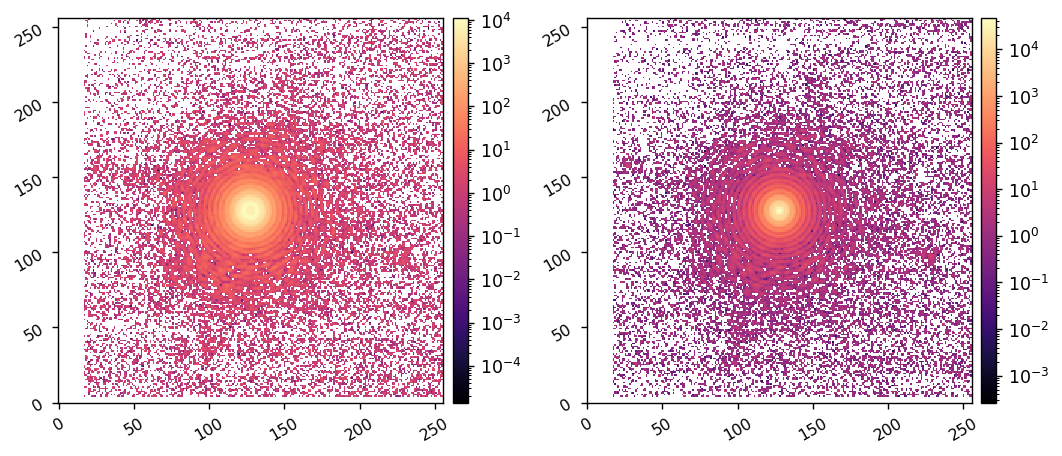

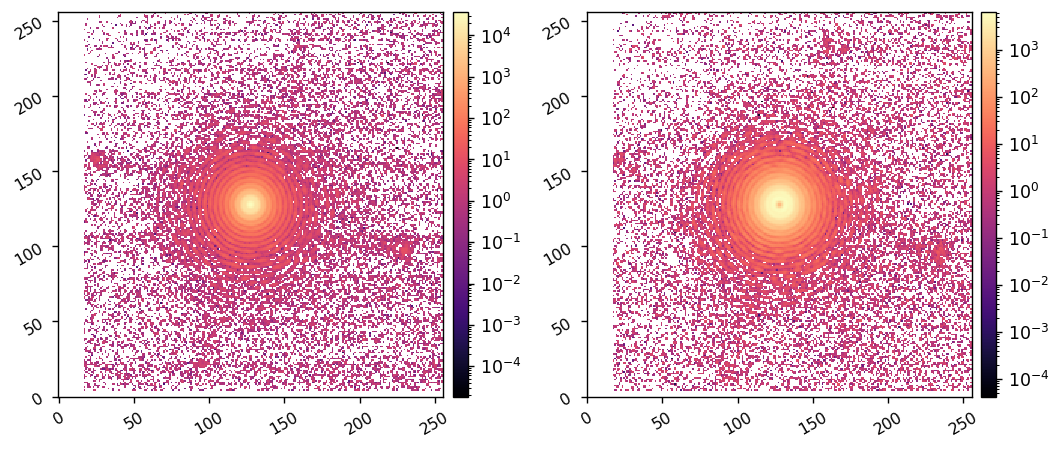

In [6]:
fdpr2_data = utils.load_pickle('data/20250113_fdpr2_ring_15.pkl')
Imeas = fdpr2_data['Imeas']
imshow2(Imeas[0], Imeas[1], lognorm=1)
imshow2(Imeas[2], Imeas[3], lognorm=1)

2.0 1e-07 0.0 175.0


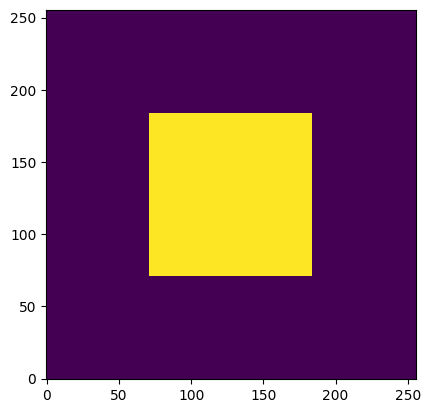

In [7]:
# parse configuration
probevals = np.asarray(config_params.get_param('diversity', 'probevals', float))
wavelen = config_params.get_param('estimation', 'wavelen', float)
scalefactor = config_params.get_param('estimation', 'scalefactor', float)
N = config_params.get_param('estimation', 'N', int)
nside = config_params.get_param('estimation', 'Nfit', int)
tol = config_params.get_param('estimation', 'tol0', float)
reg = config_params.get_param('estimation', 'reg', float)
wreg = config_params.get_param('estimation', 'wreg', float)
print(scalefactor, tol, reg, wreg)

fitmask, fitslice = tools.get_fitting_region( (N,N), nside)
plt.imshow(fitmask)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [28]:
tools.run_phase_retrieval

<function magpyx.fdpr2.estimation.run_phase_retrieval(Imeas, fitmask, tol, reg, wreg, Eprobes, init_params=None, bounds=True, modes=None, fit_amp=True)>

In [8]:
# run the estimation
estdict = tools.run_phase_retrieval(Imeas, fitmask, tol, reg, wreg, Eprobes)

In [9]:
# amplitude mask and zernikes
amp = estdict['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict['amp_est'] > amp_thresh

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [10]:
coeffs = np.sum(zmodes*estdict['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem = estdict['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

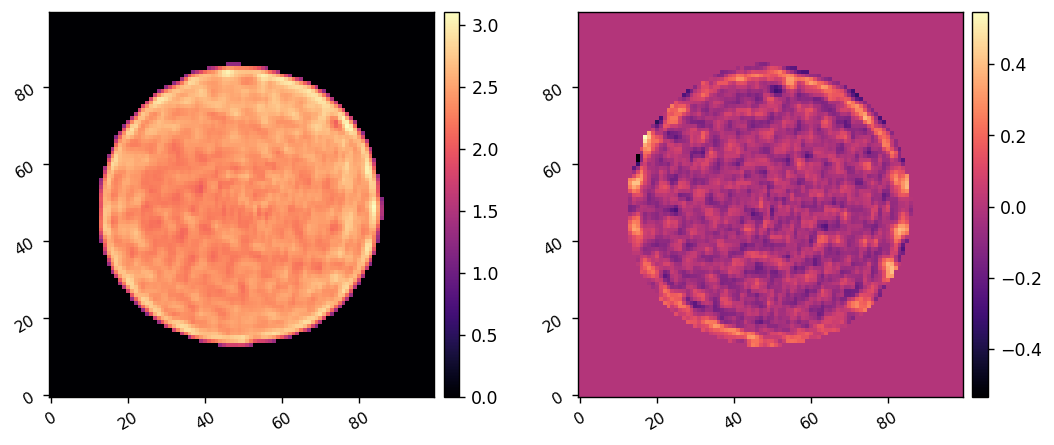

In [11]:
imshows.imshow2(amp*mask, phase_ttrem*mask, npix=100)

# pad measured PSFs for higher resolution in retrieved phase

In [12]:
pad_factor = 2
N = Imeas.shape[1]*pad_factor
side_pad = (N-Imeas.shape[1])//2
print(N, side_pad)

Imeas_2 = np.pad(
    Imeas, 
    ((0,0), (side_pad, side_pad), (side_pad, side_pad))
)
Imeas_2.shape

512 128


(4, 512, 512)

In [57]:
nside*pad_factor

226

In [13]:
fitmask, fitslice = tools.get_fitting_region((N, N), 2*113)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [14]:
# let's try passing in upscaled version of previous estimate as starting point
from scipy.ndimage import zoom

amp_input = zoom(estdict['amp_est'], pad_factor)
phase_input = zoom(phase_ttrem, pad_factor)

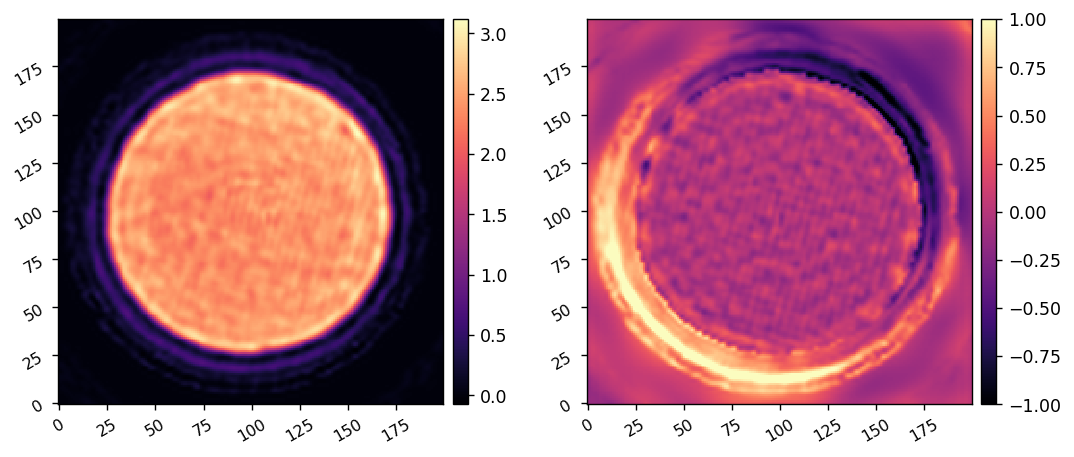

In [15]:
imshows.imshow2(amp_input, phase_input, npix=200, vmin2=-1, vmax2=1)


In [16]:
init_params = np.concatenate([amp_input[fitmask], phase_input[fitmask]], axis=0)
estdict_2 = tools.run_phase_retrieval(Imeas_2, fitmask, tol, reg, wreg, Eprobes, init_params=init_params)

In [17]:
amp_2 = estdict_2['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict_2['amp_est'] > amp_thresh
mask = binary_erosion(mask, iterations=1) # clean up stray pixels

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [18]:
coeffs = np.sum(zmodes*estdict_2['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem_2 = estdict_2['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

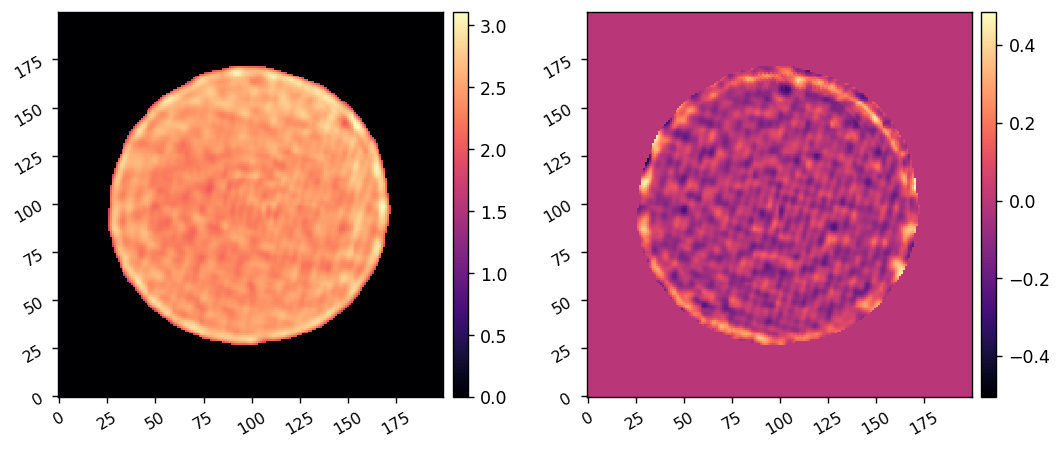

In [19]:
imshows.imshow2(amp_2*mask, phase_ttrem_2 * mask, npix=200)

# Now do it again.

In [20]:
pad_factor = 2
N = Imeas_2.shape[1]*pad_factor
side_pad = (N-Imeas_2.shape[1])//2
print(N, side_pad)

Imeas_3 = np.pad(
    Imeas_2, 
    ((0,0), (side_pad, side_pad), (side_pad, side_pad))
)
Imeas_3.shape

1024 256


(4, 1024, 1024)

In [21]:
fitmask, fitslice = tools.get_fitting_region((N, N), 4*113)
Eprobes = tools.get_defocus_probes(fitmask, probevals, wavelen, scalefactor=scalefactor)

In [22]:
# let's try passing in upscaled version of previous estimate as starting point
from scipy.ndimage import zoom

amp_input = zoom(estdict_2['amp_est'], pad_factor)
phase_input = zoom(phase_ttrem_2, pad_factor)

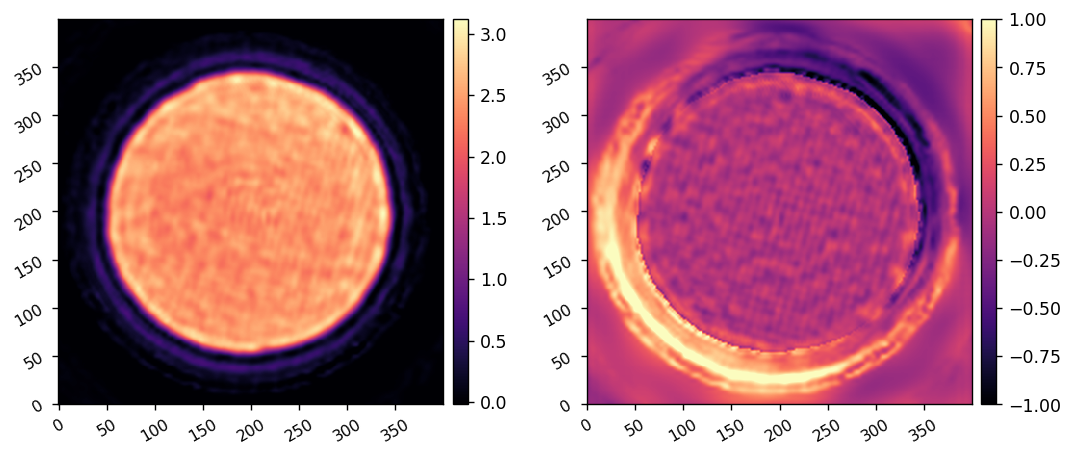

In [23]:
imshows.imshow2(amp_input, phase_input, npix=400, vmin2=-1, vmax2=1)


In [24]:
init_params = np.concatenate([amp_input[fitmask], phase_input[fitmask]], axis=0)
estdict_3 = tools.run_phase_retrieval(Imeas_3, fitmask, tol, reg, wreg, Eprobes, init_params=init_params)

In [25]:
amp_3 = estdict_3['amp_est']
amp_thresh = tools.threshold_otsu(estdict['amp_est'])
mask = estdict_3['amp_est'] > amp_thresh
mask = binary_erosion(mask, iterations=1) # clean up stray pixels

zmodes = zernike.arbitrary_basis(cp.array(mask), nterms=3, outside=0).get()

In [26]:
coeffs = np.sum(zmodes*estdict_3['phase_est'], axis=(-2,-1)) / zmodes[0].sum()
phase_ttrem_3 = estdict_3['phase_est'] - np.sum(coeffs[:,None,None] * zmodes, axis=0)

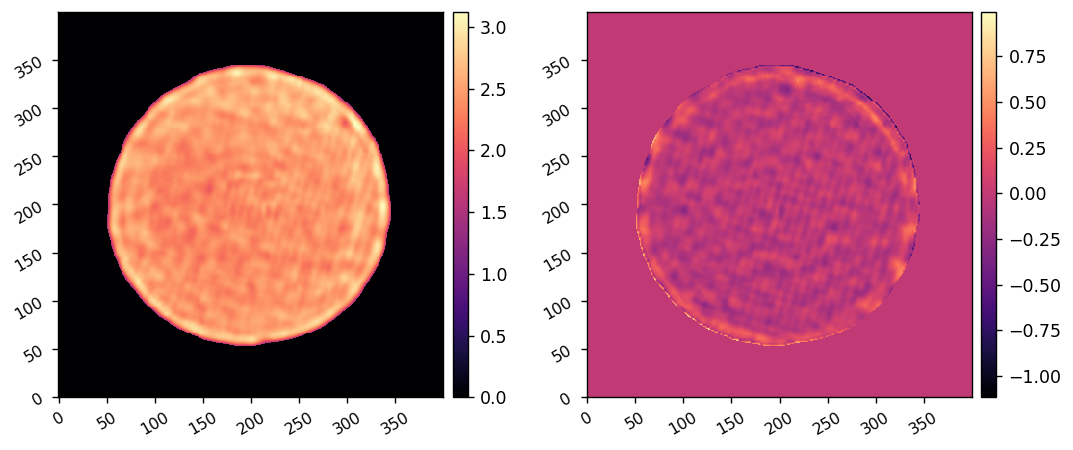

In [27]:
imshows.imshow2(amp_3*mask, phase_ttrem_3 * mask, npix=400)

In [80]:
estdict_3.update({'phase_est_ttrem':phase_ttrem_3})
estdict_3.keys()

dict_keys(['phase_est', 'amp_est', 'obj_val', 'fit_params', 'fitdict', 'phase_est_ttrem'])

In [81]:
import pickle

def save_pickle(fpath, data, quiet=False):
    out = open(str(fpath), 'wb')
    pickle.dump(data, out)
    out.close()
    if not quiet: print('Saved data to: ', str(fpath))

def load_pickle(fpath):
    infile = open(str(fpath),'rb')
    pkl_data = pickle.load(infile)
    infile.close()
    return pkl_data

In [82]:


save_pickle('fpm_pr_data_20250107.pkl', estdict)

Saved data to:  fpm_pr_data_20250107.pkl
